In [ ]:
!conda install boto3 -y
!conda install pandas -y
!conda install numpy -y
!conda install fsspec -y
!conda install s3fs -y
!conda install matplotlib -y

In [3]:
import boto3
import configparser
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# Load AWS credentials from the configuration file for BOTO3
config = configparser.ConfigParser()
config.read('aws.cfg')

aws_access_key = config['AWS']['aws_access_key_id']
aws_secret_key = config['AWS']['aws_secret_access_key']

# Initialize the S3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)
comprehend = boto3.client(service_name='comprehend',region_name='us-west-2',aws_access_key_id= aws_access_key,aws_secret_access_key=aws_secret_key)
rekognition = boto3.client(service_name='rekognition', region_name='us-west-2', aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)

In [44]:
prod_df = pd.read_csv('s3://techcatalyst-public/resources/sentiment/product.csv')
rvw_df = pd.read_csv('s3://techcatalyst-public/resources/sentiment/review.csv')

In [45]:
prod_df.info()
rvw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT ID           20 non-null     int64 
 1   PRODUCT DESCRIPTION  20 non-null     object
 2   REVIEW ID            20 non-null     object
dtypes: int64(1), object(2)
memory usage: 612.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   REVIEW ID    20 non-null     object
 1   REVIEW TEXT  20 non-null     object
dtypes: object(2)
memory usage: 452.0+ bytes


In [46]:
merged_df = prod_df.merge(rvw_df, on='REVIEW ID')

In [47]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT ID           20 non-null     int64 
 1   PRODUCT DESCRIPTION  20 non-null     object
 2   REVIEW ID            20 non-null     object
 3   REVIEW TEXT          20 non-null     object
dtypes: int64(1), object(3)
memory usage: 772.0+ bytes


In [48]:
merged_df[0:3]

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b..."
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...


In [24]:
# function for performing sentiment analysis on each column value
def get_sentiment(mytxt):
     
    response = comprehend.detect_sentiment(
    Text= mytxt,
    LanguageCode='en')
     
    return response['Sentiment']

In [25]:
merged_df['Sentiment'] = merged_df['REVIEW TEXT'].apply(lambda x: get_sentiment(str(x)))

In [26]:
merged_df[0:5]

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT,Sentiment
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b...",MIXED
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...,POSITIVE
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...,POSITIVE
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.,NEGATIVE
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.,POSITIVE


In [29]:
bucket_name = 'techcatalyst-public'
dst = f's3://{bucket_name}/ben/product_sentiment.csv'
merged_df.to_csv(dst, storage_options={'key':aws_access_key,'secret':aws_secret_key})

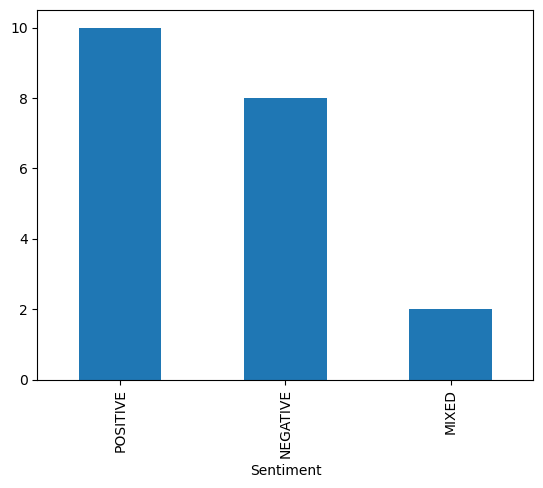

In [52]:
ax = merged_df['Sentiment'].value_counts().plot(kind='bar')
plt.savefig('sentiment_graph.jpg', format='jpg')
s3.upload_file('sentiment_graph.jpg','techcatalyst-public','ben/sentiment_graph.jpg')

In [33]:
response = s3.list_objects_v2(Bucket='techcatalyst-public', Prefix='resources/license-plates')
contents = response['Contents'][1:-1]

license_list = []
for item in contents:
    license_list.append(item['Key'])
license_list


['resources/license-plates/license_plate10.jpeg',
 'resources/license-plates/license_plate11.png',
 'resources/license-plates/license_plate12.jpeg',
 'resources/license-plates/license_plate13.jpeg',
 'resources/license-plates/license_plate3.png',
 'resources/license-plates/license_plate4.jpeg',
 'resources/license-plates/license_plate6.jpeg',
 'resources/license-plates/license_plate7.jpg',
 'resources/license-plates/license_plate8.png',
 'resources/license-plates/license_plate9.jpeg']

In [11]:
states = [
    "ALABAMA", "ALASKA", "ARIZONA", "ARKANSAS", "CALIFORNIA", "COLORADO", "CONNECTICUT",
    "DELAWARE", "FLORIDA", "GEORGIA", "HAWAII", "IDAHO", "ILLINOIS", "INDIANA", "IOWA",
    "KANSAS", "KENTUCKY", "LOUISIANA", "MAINE", "MARYLAND", "MASSACHUSETTS", "MICHIGAN",
    "MINNESOTA", "MISSISSIPPI", "MISSOURI", "MONTANA", "NEBRASKA", "NEVADA", "NEW HAMPSHIRE",
    "NEW JERSEY", "NEW MEXICO", "NEW YORK", "NORTH CAROLINA", "NORTH DAKOTA", "OHIO", "OKLAHOMA",
    "OREGON", "PENNSYLVANIA", "RHODE ISLAND", "SOUTH CAROLINA", "SOUTH DAKOTA", "TENNESSEE", "TEXAS",
    "UTAH", "VERMONT", "VIRGINIA", "WASHINGTON", "WEST VIRGINIA", "WISCONSIN", "WYOMING"
]


In [16]:
bucket_name = 'techcatalyst-public'

def detect_license_state(bucket, key):
    idx = 0
    response = rekognition.detect_text(Image={'S3Object':{'Bucket':bucket,'Name':key}})
    for text in response['TextDetections']:
        if text['DetectedText'].upper() in states:
            idx += 1
            print(idx, text)


In [17]:
for image in license_list:
    detect_license_state(bucket_name, image)

1 {'DetectedText': 'ARIZONA', 'Type': 'LINE', 'Id': 0, 'Confidence': 98.50362396240234, 'Geometry': {'BoundingBox': {'Width': 0.4936508238315582, 'Height': 0.07825587689876556, 'Left': 0.26605865359306335, 'Top': 0.19211511313915253}, 'Polygon': [{'X': 0.26668664813041687, 'Y': 0.19211511313915253}, {'X': 0.7597094774246216, 'Y': 0.19995105266571045}, {'X': 0.7590815424919128, 'Y': 0.2703709900379181}, {'X': 0.26605865359306335, 'Y': 0.26253506541252136}]}}
2 {'DetectedText': 'ARIZONA', 'Type': 'WORD', 'Id': 7, 'ParentId': 0, 'Confidence': 98.50362396240234, 'Geometry': {'BoundingBox': {'Width': 0.4936508238315582, 'Height': 0.07825587689876556, 'Left': 0.26605865359306335, 'Top': 0.19211511313915253}, 'Polygon': [{'X': 0.26668664813041687, 'Y': 0.19211511313915253}, {'X': 0.7597094774246216, 'Y': 0.19995105266571045}, {'X': 0.7590815424919128, 'Y': 0.2703709900379181}, {'X': 0.26605865359306335, 'Y': 0.26253506541252136}]}}
1 {'DetectedText': 'TEXAS', 'Type': 'LINE', 'Id': 0, 'Confide

In [28]:
bucket_name = 'techcatalyst-public'

# This ensures that I only return one reference of the state per image
def detect_license_state(bucket, key):
    idx = 1
    response = rekognition.detect_text(Image={'S3Object':{'Bucket':bucket,'Name':key}})
    for text in response['TextDetections']:
        if text['DetectedText'].upper() in states and idx > 0:
            idx -= 1
            return(text['DetectedText'])

In [39]:
detected_states = []
for image in license_list:
    detected_states.append({'Image':image, 'State':detect_license_state(bucket_name,image).title()})

In [40]:
detected_states

[{'Image': 'resources/license-plates/license_plate10.jpeg',
  'State': 'Arizona'},
 {'Image': 'resources/license-plates/license_plate11.png', 'State': 'Texas'},
 {'Image': 'resources/license-plates/license_plate12.jpeg', 'State': 'Texas'},
 {'Image': 'resources/license-plates/license_plate13.jpeg',
  'State': 'Alabama'},
 {'Image': 'resources/license-plates/license_plate3.png',
  'State': 'Massachusetts'},
 {'Image': 'resources/license-plates/license_plate4.jpeg',
  'State': 'Pennsylvania'},
 {'Image': 'resources/license-plates/license_plate6.jpeg',
  'State': 'California'},
 {'Image': 'resources/license-plates/license_plate7.jpg', 'State': 'Nevada'},
 {'Image': 'resources/license-plates/license_plate8.png', 'State': 'Ohio'},
 {'Image': 'resources/license-plates/license_plate9.jpeg', 'State': 'Alabama'}]

In [41]:
states_df = pd.DataFrame(detected_states)
states_df

,Image,State
0,resources/license-plates/license_plate10.jpeg,Arizona
1,resources/license-plates/license_plate11.png,Texas
2,resources/license-plates/license_plate12.jpeg,Texas
3,resources/license-plates/license_plate13.jpeg,Alabama
4,resources/license-plates/license_plate3.png,Massachusetts
5,resources/license-plates/license_plate4.jpeg,Pennsylvania
6,resources/license-plates/license_plate6.jpeg,California
7,resources/license-plates/license_plate7.jpg,Nevada
8,resources/license-plates/license_plate8.png,Ohio
9,resources/license-plates/license_plate9.jpeg,Alabama


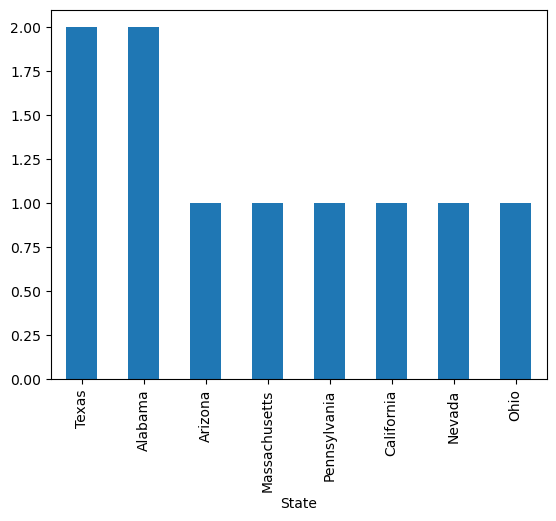

In [42]:
ax = states_df['State'].value_counts().plot(kind='bar')
plt.savefig('states_graph.jpg', format='jpg')
s3.upload_file('states_graph.jpg','techcatalyst-public','ben/states_graph.jpg')